In [2]:
import pandas as pd
import numpy as np

In [3]:
df_check = pd.read_parquet("data/df_agg.parquet")
print(df_check.head())
print(df_check.dtypes)

                                         customer_ID  P_2_mean   P_2_std  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.933824  0.024194   
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  0.899820  0.022119   
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  0.878454  0.028911   
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  0.598969  0.020108   
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...  0.891679  0.042325   

    P_2_min   P_2_max  P_2_last  D_39_mean  D_39_std  D_39_min  D_39_max  ...  \
0  0.868580  0.960384  0.934745   0.010704  0.024444  0.001082  0.091505  ...   
1  0.861109  0.929122  0.880519   0.215205  0.199150  0.002224  0.567403  ...   
2  0.797670  0.904482  0.880875   0.004181  0.002758  0.000802  0.009704  ...   
3  0.567442  0.623392  0.621776   0.048862  0.088466  0.000660  0.268476  ...   
4  0.805045  0.940382  0.871900   0.004644  0.002882  0.000030  0.008680  ...   

   D_144_std  D_144_min  D_144_max  D_144_last  D_145_me

In [4]:
X = df_check.drop(columns=["target"])
y = df_check["target"]


In [5]:
#splitting the data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
!pip install lightgbm

In [7]:
# Remove object columns (like IDs)
X_train = X_train.select_dtypes(include=["number", "bool"])
X_valid = X_valid.select_dtypes(include=["number", "bool"])

# Or if you know the specific column(s)
# X_train = X_train.drop(columns=["customer_ID"])
# X_valid = X_valid.drop(columns=["customer_ID"])


In [8]:
import lightgbm as lgb
import numpy as np

# compute scale_pos_weight from training labels (recommended for imbalanced targets)
# If you already computed it, you can hard-code it. Otherwise this is safe:
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos if pos > 0 else 1.0
print("scale_pos_weight:", scale_pos_weight)

params = {
    # core
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'seed': 42,
    'verbosity': -1,

    # learning / complexity
    'learning_rate': 0.03,     # slower learning for stability (try 0.01-0.05)
    'num_leaves': 64,          # controls tree complexity (2^depth - 1); 31-128 typical
    'max_depth': -1,           # -1 = no limit (num_leaves controls complexity)
    'min_data_in_leaf': 100,   # regularization for small leaves; tune down if dataset small

    # regularization
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'min_split_gain': 0.01,

    # subsampling / features
    'feature_fraction': 0.8,   # column subsample each iteration
    'bagging_fraction': 0.8,   # row subsample
    'bagging_freq': 5,         # perform bagging every k iterations

    # imbalance handling (important for AmEx)
    'is_unbalance': False,            # set False if using scale_pos_weight
    'scale_pos_weight': float(scale_pos_weight),

    # output
    'force_row_wise': True  # sometimes helps with newer LightGBM versions for speed/memory
}

# Training recipe
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=5000,
    valid_sets=[lgb_valid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)


scale_pos_weight: 2.6869806094182827
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.928854
[200]	valid_0's auc: 0.929177
Early stopping, best iteration is:
[178]	valid_0's auc: 0.930558


In [9]:
import lightgbm as lgb
model = lgb.Booster(model_file="lgbm_model.txt")
print("Model loaded")


Model loaded


In [22]:
from sklearn.metrics import roc_auc_score

y_pred_prob = model.predict(X_valid)
auc = roc_auc_score(y_valid, y_pred_prob)
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.9306


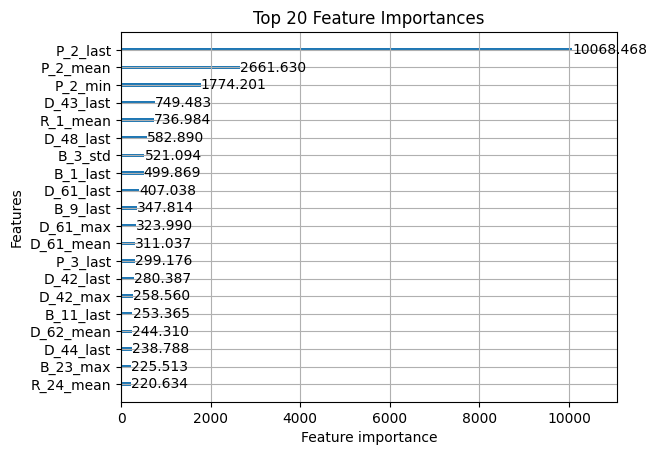

In [23]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Plot top 20 features by importance (gain)
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.show()


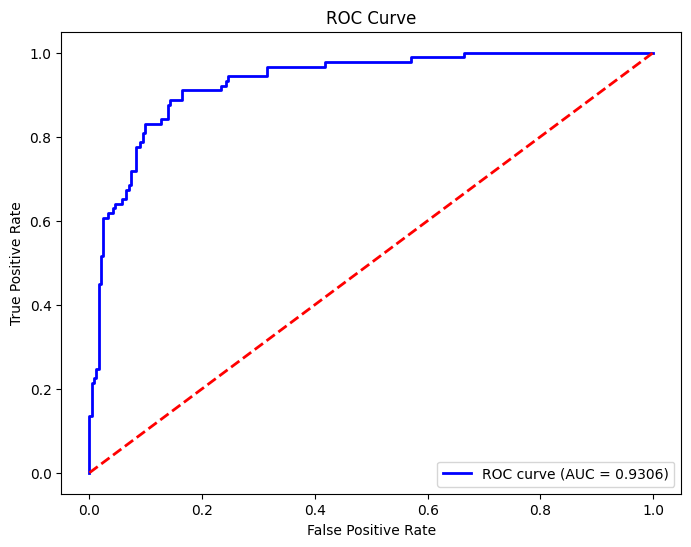

In [24]:
#plot roc curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [18]:
import requests
from pathlib import Path
from tqdm import tqdm
import zipfile
import os

# Where to save data
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# Kaggle credentials
KAGGLE_USERNAME = "vaishnavibodla"
KAGGLE_KEY = "6d1f311e4fe7b274e982ff995024378d"

def download_file(file_name):
    url = f"https://www.kaggle.com/api/v1/competitions/data/download/amex-default-prediction/{file_name}"
    auth = (KAGGLE_USERNAME, KAGGLE_KEY)
    headers = {"User-Agent": "Mozilla/5.0"}
    zip_path = DATA_DIR / f"{file_name}.zip"

    print(f"⬇️ Downloading {file_name}...")

    with requests.get(url, stream=True, auth=auth, headers=headers) as r:
        r.raise_for_status()
        total_size = int(r.headers.get("content-length", 0))
        with open(zip_path, "wb") as f:
            for chunk in tqdm(r.iter_content(chunk_size=1024 * 1024),  # 1MB chunks
                              total=max(total_size // (1024 * 1024), 1),
                              unit="MB"):
                f.write(chunk)

    print(f"✅ Downloaded {file_name}. Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    os.remove(zip_path)
    print(f"🧹 Cleaned up {file_name}.zip")

# Download only the test dataset
download_file("test_data.csv")


⬇️ Downloading test_data.csv...


14089MB [01:45, 133.44MB/s]                           


✅ Downloaded test_data.csv. Extracting...
🧹 Cleaned up test_data.csv.zip


In [2]:
# Install Dask and its CSV/Parquet dependencies
!pip install dask[complete] --quiet


In [1]:
import glob
len(glob.glob("data/test_chunks_exact/chunk_exact_*.parquet"))


0

In [2]:
# 1) Produce exact per-chunk statistics: sum, count, sumsq, min, max (resumable)
import os, glob, pandas as pd, gc

INPUT_CSV = "data/test_data.csv"
OUT_DIR = "data/test_chunks_exact"   # new folder for exact stats
os.makedirs(OUT_DIR, exist_ok=True)

# reduce chunk size if you previously crashed; increase if you have plenty of RAM
chunksize = 300_000  

existing = sorted(glob.glob(os.path.join(OUT_DIR, "chunk_exact_*.parquet")))
done_idxs = {int(os.path.basename(f).split("_")[2].split(".")[0]) for f in existing} if existing else set()
print("already done chunks:", sorted(done_idxs)[:10], "total done:", len(done_idxs))

reader = pd.read_csv(INPUT_CSV, chunksize=chunksize)
for i, chunk in enumerate(reader):
    if i in done_idxs:
        print(f"skip chunk {i}")
        continue

    print(f"processing chunk {i} rows={len(chunk)}")
    # ensure customer_ID is string
    chunk['customer_ID'] = chunk['customer_ID'].astype(str)

    # select numeric columns (exclude customer_ID)
    numeric_cols = chunk.select_dtypes(include=['number']).columns.tolist()
    if 'customer_ID' in numeric_cols:
        numeric_cols.remove('customer_ID')

    # compute sum, count, min, max per customer (these are exact)
    grp = chunk.groupby('customer_ID')[numeric_cols].agg(['sum', 'count', 'max', 'min'])
    # flatten columns e.g., B_1_sum, B_1_count, ...
    grp.columns = ['_'.join(col).strip() for col in grp.columns.values]
    grp = grp.reset_index()

    # compute sumsq for each numeric column (needed for exact std later)
    # do it in a memory-efficient way
    sq = chunk[numeric_cols].pow(2)
    sq['customer_ID'] = chunk['customer_ID']
    grp_sumsq = sq.groupby('customer_ID').agg('sum').reset_index()
    # rename sumsq columns
    grp_sumsq.columns = ['customer_ID'] + [f"{c}_sumsq" for c in grp_sumsq.columns if c != 'customer_ID']

    # merge sum/count/max/min with sumsq
    exact = grp.merge(grp_sumsq, on='customer_ID', how='left')

    out_path = os.path.join(OUT_DIR, f"chunk_exact_{i}.parquet")
    exact.to_parquet(out_path, index=False)
    print("saved", out_path)

    # cleanup
    del chunk, grp, sq, grp_sumsq, exact
    gc.collect()

print("done creating exact per-chunk stats.")


already done chunks: [] total done: 0
processing chunk 0 rows=300000
saved data/test_chunks_exact/chunk_exact_0.parquet
processing chunk 1 rows=300000
saved data/test_chunks_exact/chunk_exact_1.parquet
processing chunk 2 rows=300000
saved data/test_chunks_exact/chunk_exact_2.parquet
processing chunk 3 rows=300000
saved data/test_chunks_exact/chunk_exact_3.parquet
processing chunk 4 rows=300000
saved data/test_chunks_exact/chunk_exact_4.parquet
processing chunk 5 rows=300000
saved data/test_chunks_exact/chunk_exact_5.parquet
processing chunk 6 rows=300000
saved data/test_chunks_exact/chunk_exact_6.parquet
processing chunk 7 rows=300000
saved data/test_chunks_exact/chunk_exact_7.parquet
processing chunk 8 rows=300000
saved data/test_chunks_exact/chunk_exact_8.parquet
processing chunk 9 rows=300000
saved data/test_chunks_exact/chunk_exact_9.parquet
processing chunk 10 rows=300000
saved data/test_chunks_exact/chunk_exact_10.parquet
processing chunk 11 rows=300000
saved data/test_chunks_exa

In [3]:
# 2) Batch-merge per-chunk exact files in rounds (reduce) — memory-friendly
import glob, os, pandas as pd, gc
PER_DIR = "data/test_chunks_exact"   # created above
OUT_DIR = "data/test_chunks_merged"
os.makedirs(OUT_DIR, exist_ok=True)

files = sorted(glob.glob(os.path.join(PER_DIR, "chunk_exact_*.parquet")))
print("input exact chunk files:", len(files))
if len(files) == 0:
    raise RuntimeError("No exact chunk files found. Run the exact-chunk cell first.")

# merge in small batches: concat a few files, groupby to reduce, save intermediate file.
batch_size = 6   # number of files to merge at once; reduce if memory issues
round_idx = 0
current_files = files.copy()

while len(current_files) > 1:
    print(f"--- Merge round {round_idx} | {len(current_files)} files to merge ---")
    next_round_files = []
    for k in range(0, len(current_files), batch_size):
        subset = current_files[k:k+batch_size]
        print(f" Merging subset {k}..{k+len(subset)-1}, {len(subset)} files")
        # load subset
        dfs = [pd.read_parquet(f) for f in subset]
        df = pd.concat(dfs, ignore_index=True)
        # ensure customer_ID string
        df['customer_ID'] = df['customer_ID'].astype(str)

        # Now combine rows for same customer within this subset by summing sums and counts and sumsq, and taking global min/max
        # columns structure example: B_1_sum, B_1_count, B_1_max, B_1_min, B_1_sumsq, ...
        # find unique base feature names (strip suffixes)
        cols = [c for c in df.columns if c != 'customer_ID']
        bases = set([c.rsplit('_', 1)[0] for c in cols])

        agg_dict = {}
        for base in bases:
            # sum-like columns
            if f"{base}_sum" in df.columns:
                agg_dict[f"{base}_sum"] = 'sum'
            if f"{base}_count" in df.columns:
                agg_dict[f"{base}_count"] = 'sum'   # counts add
            if f"{base}_sumsq" in df.columns:
                agg_dict[f"{base}_sumsq"] = 'sum'   # sumsq add
            if f"{base}_max" in df.columns:
                agg_dict[f"{base}_max"] = 'max'
            if f"{base}_min" in df.columns:
                agg_dict[f"{base}_min"] = 'min'

        # perform groupby aggregation (this reduces memory because duplicates per customer within subset are combined)
        reduced = df.groupby('customer_ID').agg(agg_dict).reset_index()

        # write intermediate merged file
        out_path = os.path.join(OUT_DIR, f"merged_round{round_idx}_{k//batch_size}.parquet")
        reduced.to_parquet(out_path, index=False)
        print(" wrote", out_path)

        # clean up
        del dfs, df, reduced
        gc.collect()
        next_round_files.append(out_path)

    # prepare for next round
    current_files = next_round_files
    round_idx += 1

# after loop, current_files should be length 1: the final merged file
final_file = current_files[0]
print("Final merged file:", final_file)

# load final merged file
final = pd.read_parquet(final_file)
print("Final shape (rows=customers):", final.shape)
final.head()


input exact chunk files: 38
--- Merge round 0 | 38 files to merge ---
 Merging subset 0..5, 6 files
 wrote data/test_chunks_merged/merged_round0_0.parquet
 Merging subset 6..11, 6 files
 wrote data/test_chunks_merged/merged_round0_1.parquet
 Merging subset 12..17, 6 files
 wrote data/test_chunks_merged/merged_round0_2.parquet
 Merging subset 18..23, 6 files
 wrote data/test_chunks_merged/merged_round0_3.parquet
 Merging subset 24..29, 6 files
 wrote data/test_chunks_merged/merged_round0_4.parquet
 Merging subset 30..35, 6 files
 wrote data/test_chunks_merged/merged_round0_5.parquet
 Merging subset 36..37, 2 files
 wrote data/test_chunks_merged/merged_round0_6.parquet
--- Merge round 1 | 7 files to merge ---
 Merging subset 0..5, 6 files
 wrote data/test_chunks_merged/merged_round1_0.parquet
 Merging subset 6..6, 1 files
 wrote data/test_chunks_merged/merged_round1_1.parquet
--- Merge round 2 | 2 files to merge ---
 Merging subset 0..1, 2 files
 wrote data/test_chunks_merged/merged_roun

,customer_ID,B_30_sum,B_30_count,B_30_sumsq,B_30_max,B_30_min,B_36_sum,B_36_count,B_36_sumsq,B_36_max,...,D_121_sum,D_121_count,D_121_sumsq,D_121_max,D_121_min,D_129_sum,D_129_count,D_129_sumsq,D_129_max,D_129_min
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.0,9,0.0,0.0,0.0,0.036079,9,0.000258,0.009113,...,0.983754,5,0.193588,0.199254,0.192405,0.053446,8,0.000414,0.009961,0.002027
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0,13,0.0,0.0,0.0,0.067546,13,0.000480,0.009707,...,10.949304,13,9.222853,0.854850,0.827385,0.064955,13,0.000454,0.009173,0.000036
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.0,13,0.0,0.0,0.0,0.077375,13,0.000540,0.009374,...,3.537061,13,0.962821,0.280907,0.262928,0.077237,13,0.000565,0.009323,0.000395
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,3.0,13,3.0,1.0,0.0,0.054241,13,0.000321,0.009784,...,2.740840,13,0.578778,0.223874,0.198072,0.067922,13,0.000496,0.009921,0.000112
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,10.0,13,10.0,1.0,0.0,0.054272,13,0.000331,0.009777,...,2.012392,13,0.312440,0.170112,0.141394,7.062339,13,7.079239,1.008821,0.000478


In [1]:
import glob

files = glob.glob("data/test_chunks_exact/chunk_exact_*.parquet")
print("Exact files found:", len(files))


Exact files found: 38


In [2]:
# 2) Batch-merge per-chunk exact files in rounds (reduce) — memory-friendly
import glob, os, pandas as pd, gc

PER_DIR = "data/test_chunks_exact"   # where exact per-chunk files are stored
OUT_DIR = "data/test_chunks_merged"  # will store merged intermediate files
os.makedirs(OUT_DIR, exist_ok=True)

files = sorted(glob.glob(os.path.join(PER_DIR, "chunk_exact_*.parquet")))
print("input exact chunk files:", len(files))
if len(files) == 0:
    raise RuntimeError("No exact chunk files found. Run the exact-chunk cell first.")

batch_size = 6  # reduce to 3 if low RAM
round_idx = 0
current_files = files.copy()

while len(current_files) > 1:
    print(f"--- Merge round {round_idx} | {len(current_files)} files to merge ---")
    next_round_files = []

    for k in range(0, len(current_files), batch_size):
        subset = current_files[k:k+batch_size]
        print(f" Merging subset {k}..{k+len(subset)-1}, {len(subset)} files")

        # load subset
        dfs = [pd.read_parquet(f) for f in subset]
        df = pd.concat(dfs, ignore_index=True)
        df['customer_ID'] = df['customer_ID'].astype(str)

        # build aggregation dictionary
        cols = [c for c in df.columns if c != 'customer_ID']
        bases = set([c.rsplit('_', 1)[0] for c in cols])

        agg_dict = {}
        for base in bases:
            if f"{base}_sum" in df.columns:
                agg_dict[f"{base}_sum"] = 'sum'
            if f"{base}_count" in df.columns:
                agg_dict[f"{base}_count"] = 'sum'
            if f"{base}_sumsq" in df.columns:
                agg_dict[f"{base}_sumsq"] = 'sum'
            if f"{base}_max" in df.columns:
                agg_dict[f"{base}_max"] = 'max'
            if f"{base}_min" in df.columns:
                agg_dict[f"{base}_min"] = 'min'

        # reduce within this batch
        reduced = df.groupby('customer_ID').agg(agg_dict).reset_index()

        out_path = os.path.join(OUT_DIR, f"merged_round{round_idx}_{k//batch_size}.parquet")
        reduced.to_parquet(out_path, index=False)
        print("  wrote", out_path)

        del dfs, df, reduced
        gc.collect()

        next_round_files.append(out_path)

    current_files = next_round_files
    round_idx += 1

# final output file
final_file = current_files[0]
print("\nFINAL MERGED FILE:", final_file)


input exact chunk files: 38
--- Merge round 0 | 38 files to merge ---
 Merging subset 0..5, 6 files
  wrote data/test_chunks_merged/merged_round0_0.parquet
 Merging subset 6..11, 6 files
  wrote data/test_chunks_merged/merged_round0_1.parquet
 Merging subset 12..17, 6 files
  wrote data/test_chunks_merged/merged_round0_2.parquet
 Merging subset 18..23, 6 files
  wrote data/test_chunks_merged/merged_round0_3.parquet
 Merging subset 24..29, 6 files
  wrote data/test_chunks_merged/merged_round0_4.parquet
 Merging subset 30..35, 6 files
  wrote data/test_chunks_merged/merged_round0_5.parquet
 Merging subset 36..37, 2 files
  wrote data/test_chunks_merged/merged_round0_6.parquet
--- Merge round 1 | 7 files to merge ---
 Merging subset 0..5, 6 files
  wrote data/test_chunks_merged/merged_round1_0.parquet
 Merging subset 6..6, 1 files
  wrote data/test_chunks_merged/merged_round1_1.parquet
--- Merge round 2 | 2 files to merge ---
 Merging subset 0..1, 2 files
  wrote data/test_chunks_merged/m

In [4]:
# STEP C: load the final merged file automatically, compute final features, save result
import glob, os, pandas as pd, numpy as np

MERGED_DIR = "data/test_chunks_merged"
OUT_FINAL = "data/test_final_aggregated.parquet"

# find merged files and pick the latest (by modification time) or the single final file
merged_files = sorted(glob.glob(os.path.join(MERGED_DIR, "merged_round*.parquet")))
if len(merged_files) == 0:
    raise FileNotFoundError(f"No merged files found in {MERGED_DIR}. Run the merge step first.")

# choose the newest merged file (safe after merging rounds)
merged_file = max(merged_files, key=os.path.getmtime)
print("Using merged file:", merged_file)

# read merged file
df = pd.read_parquet(merged_file)
print("Loaded merged shape:", df.shape)

# Ensure customer_ID is string
df['customer_ID'] = df['customer_ID'].astype(str)

# detect base feature names (strip trailing suffixes like _sum/_count/_sumsq/_max/_min)
cols = [c for c in df.columns if c != 'customer_ID']
bases = sorted({c.rsplit('_',1)[0] for c in cols})

out = pd.DataFrame()
out['customer_ID'] = df['customer_ID']

for base in bases:
    s_col = f"{base}_sum"
    c_col = f"{base}_count"
    ss_col = f"{base}_sumsq"
    max_col = f"{base}_max"
    min_col = f"{base}_min"

    # mean
    if s_col in df.columns and c_col in df.columns:
        out[f"{base}_mean"] = df[s_col] / df[c_col].replace({0: np.nan})
    # std from sums and sumsq (population variance). Clip small negatives to 0.
    if ss_col in df.columns and s_col in df.columns and c_col in df.columns:
        # var = (sumsq - sum^2/count) / count
        count = df[c_col].replace({0: np.nan})
        var = (df[ss_col] - (df[s_col]**2 / count)) / count
        var = var.clip(lower=0)
        out[f"{base}_std"] = np.sqrt(var)
    # min/max
    if max_col in df.columns:
        out[f"{base}_max"] = df[max_col]
    if min_col in df.columns:
        out[f"{base}_min"] = df[min_col]

# save final derived features
out.to_parquet(OUT_FINAL, index=False)
print("Saved final derived features to:", OUT_FINAL)
print("Final shape:", out.shape)
out.head()


Using merged file: data/test_chunks_merged/merged_round2_0.parquet
Loaded merged shape: (924621, 931)


/tmp/ipykernel_1125/1043397119.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{base}_min"] = df[min_col]
/tmp/ipykernel_1125/1043397119.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{base}_mean"] = df[s_col] / df[c_col].replace({0: np.nan})
/tmp/ipykernel_1125/1043397119.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

Saved final derived features to: data/test_final_aggregated.parquet
Final shape: (924621, 745)


,customer_ID,B_1_mean,B_1_std,B_1_max,B_1_min,B_10_mean,B_10_std,B_10_max,B_10_min,B_11_mean,...,S_7_max,S_7_min,S_8_mean,S_8_std,S_8_max,S_8_min,S_9_mean,S_9_std,S_9_max,S_9_min
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.013925,0.004037,0.021672,0.007959,0.037069,0.016782,0.063187,-0.002919,0.006187,...,0.210077,0.105587,0.271142,0.097751,0.464023,0.170728,0.015570,0.003842,0.022947,0.010773
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.052342,0.066357,0.276014,0.014187,0.298050,0.002595,0.303329,0.293422,0.035716,...,0.124283,0.032253,0.840346,0.105858,1.004984,0.604859,0.155740,0.177460,0.544298,0.018508
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.012762,0.012985,0.039697,0.001483,0.192089,0.085428,0.298906,0.079202,0.009048,...,0.208820,0.082774,0.336215,0.196308,0.759606,0.007783,0.081942,0.169018,0.551186,0.001582
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.284608,0.040880,0.309129,0.149511,0.024276,0.005772,0.032124,0.013830,0.293207,...,0.598874,0.461584,0.553826,0.110013,0.752623,0.466158,0.010063,0.004111,0.016637,0.002308
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.456779,0.070577,0.563603,0.357828,0.024420,0.007775,0.038865,0.012340,0.419153,...,0.151144,0.105129,0.281688,0.226875,0.605416,0.005059,0.006081,0.003042,0.009322,0.000601


In [10]:
import pandas as pd
df_test = pd.read_parquet("data/test_final_aggregated.parquet")
print(df_test.shape)


(924621, 745)


In [11]:
train_cols = model.feature_name()
len(train_cols)

930

In [12]:
X_test = df_test.drop(columns=["customer_ID"], errors="ignore")

# Drop extra columns
extra = [c for c in X_test.columns if c not in train_cols]
X_test = X_test.drop(columns=extra)

# Add missing columns
missing = [c for c in train_cols if c not in X_test.columns]
for c in missing:
    X_test[c] = 0.0

# Reorder exactly
X_test = X_test[train_cols]

print("Aligned test shape:", X_test.shape)


/tmp/ipykernel_1395/2639994863.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[c] = 0.0
/tmp/ipykernel_1395/2639994863.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[c] = 0.0
/tmp/ipykernel_1395/2639994863.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[c] = 0.0
/

Aligned test shape: (924621, 930)


In [13]:
preds = model.predict(X_test)

submission = pd.DataFrame({
    "customer_ID": df_test["customer_ID"],
    "prediction": preds
})

submission.to_csv("submission.csv", index=False)
print("DONE: submission.csv saved!")


DONE: submission.csv saved!
